In [ ]:
!pip install diffusers datasets transformers huggingface_hub
!kaggle datasets download -d parulpandey/emotion-dataset
!pip install accelerate -U
!pacman -S git-lfs
!pip install xformers
!pip install keybert
!unzip emotion-dataset.zip
!pip install bertopic

  Using cached transformers-4.41.0-py3-none-any.whl.metadata (43 kB)
  Using cached huggingface_hub-0.23.0-py3-none-any.whl.metadata (12 kB)
  Using cached importlib_metadata-7.1.0-py3-none-any.whl.metadata (4.7 kB)
  Using cached filelock-3.14.0-py3-none-any.whl.metadata (2.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 912.0 kB/s eta 0:00:00MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.7 MB/s eta 0:00:00
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.1 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 1.2 MB/s eta 0:00:000 kB/s eta 0:00:0101
Using cached transformers-4.41.0-py3-none-any.whl (9.1 MB)
Using cached huggingface_hub-0.2

In [34]:
import torch
import os
import numpy as np
import pandas as pd
import base64

from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, RobertaForSequenceClassification, RobertaConfig, Trainer, TrainingArguments, DataCollatorWithPadding
from datetime import datetime
from io import BytesIO
from PIL import Image
from keybert import KeyBERT
from diffusers import DiffusionPipeline
from bertopic import BERTopic
from collections import Counter

In [67]:
base_dir = None

if base_dir is None:
    base_dir = "/content/" # this is for the google colab.

In [65]:
class EmotionClassifier:
    def __init__(self, model_path=None):
        self.emotion_labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]
        self.tokenizer = AutoTokenizer.from_pretrained("roberta-base")
        config = RobertaConfig.from_pretrained("roberta-base", num_labels=6)
        if model_path:
            self.model = RobertaForSequenceClassification.from_pretrained(
                model_path, config=config
            )
        else:
            self.model = RobertaForSequenceClassification(config=config)
        self.data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)
        self.kw_model = KeyBERT()
        self.diffusion_model = DiffusionPipeline.from_pretrained(
            "stabilityai/stable-diffusion-xl-base-1.0",
            torch_dtype=torch.float16,
            use_safetensors=True,
            variant="fp16",
        )
        self.diffusion_model.to("cuda")

    def save_model(self, save_path="model/emotion_classifier"):
        self.model.save_pretrained(save_path)
        print(f"Model saved to {save_path}")

    def load_model(self, model_path="model/emotion_classifier"):
        if os.path.exists(model_path):
            self.model = RobertaForSequenceClassification.from_pretrained(model_path)
            print(f"Model loaded from {model_path}")
        else:
            print(f"Error: Model directory not found at {model_path}")

    def load_data(self, train_file, test_file):
        data_files = {"train": train_file, "test": test_file}
        dataset = load_dataset("csv", data_files=data_files)
        self.train_dataset = dataset["train"].map(self.tokenize_function, batched=True)
        self.test_dataset = dataset["test"].map(self.tokenize_function, batched=True)

    def tokenize_function(self, examples):
        return self.tokenizer(examples["text"], truncation=True)

    def train_model(self, output_dir="./model_save"):
        training_args = TrainingArguments(
            output_dir=output_dir,
            learning_rate=2e-5,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=2,
            weight_decay=0.01,
            save_strategy="epoch",
            push_to_hub=False,
        )
        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=self.train_dataset,
            eval_dataset=self.test_dataset,
            tokenizer=self.tokenizer,
            data_collator=self.data_collator,
            compute_metrics=self.compute_metrics,
        )
        trainer.train()
        trainer.evaluate()

    def compute_metrics(self, eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        accuracy = load_metric("accuracy").compute(
            predictions=predictions, references=labels
        )
        f1 = load_metric("f1").compute(
            predictions=predictions, references=labels, average="micro"
        )
        return {"accuracy": accuracy["accuracy"], "f1": f1["f1"]}

    def generate_image(self, text):
        keywords = self.kw_model.extract_keywords(
            text,
            keyphrase_ngram_range=(1, 10),
            stop_words="english",
            use_mmr=True,
            diversity=0.7,
        )
        prompt = " ".join([keyword[0] for keyword in keywords])
        image = self.diffusion_model(prompt).images[0]
        return image

    def encode_image_to_base64(self, image):
        buffered = BytesIO()
        image.save(buffered, format="PNG")
        return base64.b64encode(buffered.getvalue()).decode()

    def analyze_text(self, text):
        encoding = self.tokenizer(
            text, truncation=True, padding=True, return_tensors="pt"
        ).to("cuda")
        with torch.no_grad():
            output = self.model(**encoding)
        probs = torch.softmax(output.logits, dim=1)
        probabilities = probs.cpu().numpy()[0]

        emotion_probabilities = {
            label: prob for label, prob in zip(self.emotion_labels, probabilities)
        }

        return emotion_probabilities

    def create_journal_entry(self, author, text, favourites, is_shared, viewers):
        emotions = self.analyze_text(text)

        image = self.generate_image(text)
        image_base64 = self.encode_image_to_base64(image)

        # Extract keywords using KeyBERT
        keywords = self.kw_model.extract_keywords(
            text,
            keyphrase_ngram_range=(1, 2),
            stop_words="english",
            use_mmr=True,
            diversity=0.7
        )
        keywords = [keyword[0] for keyword in keywords]
        # Create and return the journal entry
        journal_entry = {
            "author": author,
            "text": text,
            "keywords": keywords,
            "emotions": emotions,
            "favourites": favourites,
            "createdAt": datetime.now().isoformat(),
            "isShared": is_shared,
            "viewers": viewers,
            "image": image_base64,
        }
        return journal_entry


In [66]:
class TopicExtractor:
    def __init__(self, model_path=None):
        if model_path:
            self.topic_model = BERTopic.load(model_path)
        else:
            self.topic_model = BERTopic(embedding_model="all-MiniLM-L6-v2", language="english")

    def extract_topics(self, text):
        topics, _ = self.topic_model.transform([text])
        return topics[0]

    def extract_topics_from_journal_entries(self, journal_entries):
        all_topics = []
        for entry in journal_entries:
            topics = self.extract_topics(extry['text'])
            all_topics.extend(topics)
        return all_topics

    def frequent_topics(self, journal_entries, num_topics=5):
        topics = self.extract_topics_from_journal_entries(journal_entries)
        topic_counts = Counter(topics)
        return topic_counts.most_common(num_topics)

    def update_model(self, texts):
        self.topic_model.fit(texts)

    def save_model(self, save_path=None):
        if save_path:
            self.topic_model.save(save_path)
        else:
            self.topic_model.save("./model/topic_model")

In [63]:
text_texts = []

if os.path.exists('./test_texts.csv'):
    test_texts = pd.read_csv('./test_texts.csv', index_col=0)
else:
    print(f"Error: test_texts.csv not found.")

In [42]:
classifier = EmotionClassifier()
classifier.load_data(train_file="train.csv", test_file="test.csv")
classifier.train_model(output_dir="./model/emotion_classifier")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [54]:
author = "65ddd1faa21e8586ed7b3a32"
text = test_texts.iloc[0]['text']
favourites = 0
is_shared = True
viewers = []
journal_entry = classifier.create_journal_entry(author, text, favourites, is_shared, viewers)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# Base64 to image
image_base64 = journal_entry["image"]
image_bytes = base64.b64decode(image_base64)
image = Image.open(BytesIO(image_bytes))

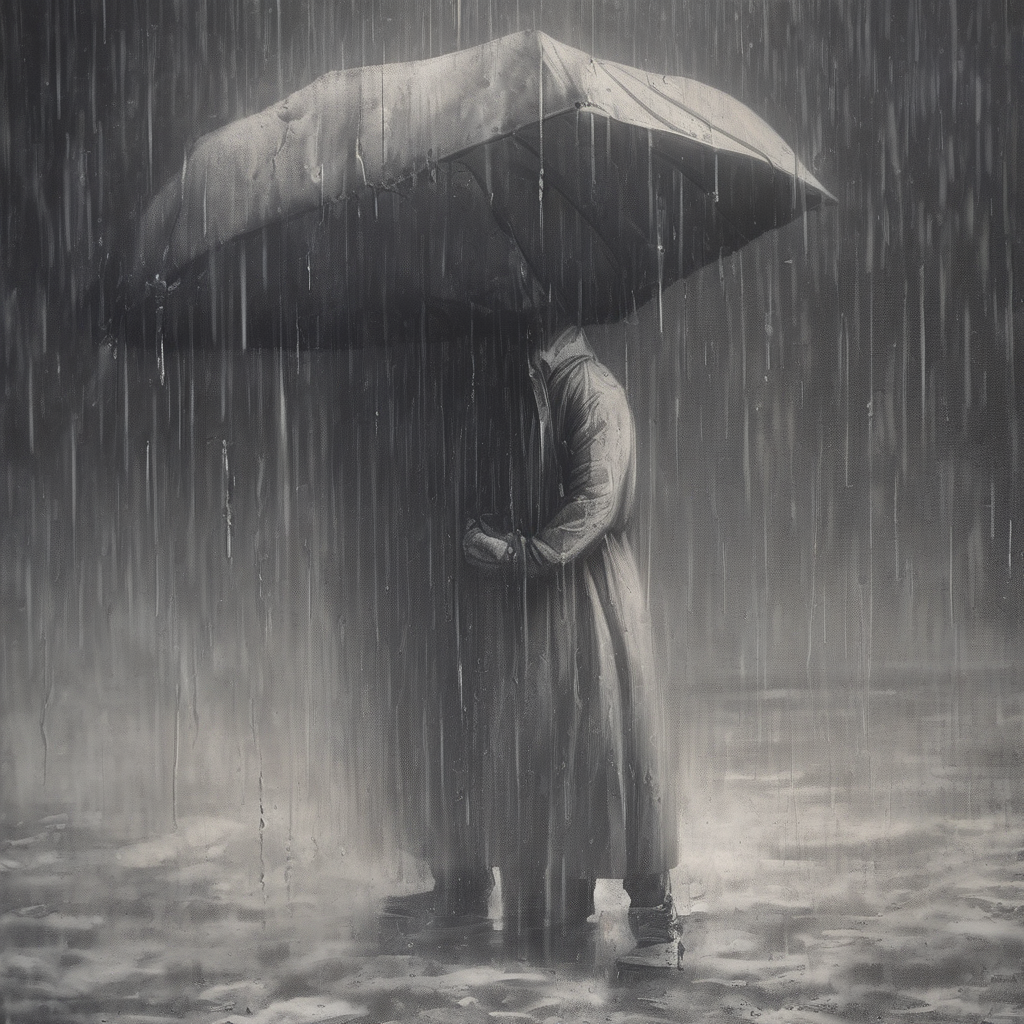

In [ ]:
image

In [ ]:
journal_entry

{'author': '65ddd1faa21e8586ed7b3a32',
 'text': 'Today felt like a never-ending spiral into darkness. From the moment I woke up, a heavy weight settled over me, suffocating any hint of joy or hope. The world seemed to mirror the turmoil within me, with grey skies and cold rain casting a bleak shadow over everything. As I went about my day, each task felt like an insurmountable hurdle. Simple chores became overwhelming, and even the smallest setbacks felt like crushing defeats. It was as if I was trapped in a never-ending cycle of frustration and despair, with no escape in sight. The weight of loneliness bore down on me, crushing my spirit with its suffocating grip. Despite being surrounded by people, I felt utterly alone, as if I was adrift in a vast ocean of emptiness. No words of comfort could penetrate the walls I had built around myself, leaving me to drown in my own sorrow. As the day drew to a close, a sense of exhaustion washed over me, both physical and emotional. I longed for 